In [27]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# Geoplots
import descartes
import geopandas as gpd 
from shapely.geometry import Point, Polygon
import geoplot as gplt
# Cluster classifications
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Linear Regression

In [4]:
# Configure plots
sns.set()
plt.rcParams['figure.figsize'] = (9,6) # size in inches 
plt.rcParams['axes.labelpad'] = 10

In [226]:
# Resulsts of linear regression
lr = pd.read_csv("data/linear_regression_results.csv").iloc[:, 1 :]

# Linear regression model
filename = "linear_regression_model.sav"
lr_model = pickle.load(open(filename, 'rb'))

# Entire data set
data = pd.read_csv("data/model_data.csv")
actual = data[['price']]
actual.columns = ["actual"]
features = data.iloc[:, 5 :]

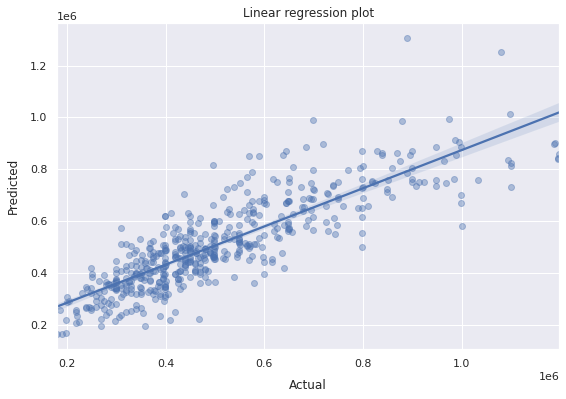

In [218]:
# Regression plot 
sns.regplot('Actual', 'Predicted', lr, scatter_kws={'alpha':0.4})
plt.title("Linear regression plot")
plt.savefig('figures/lr_plot.png', bbox_inches='tight', dpi=300)

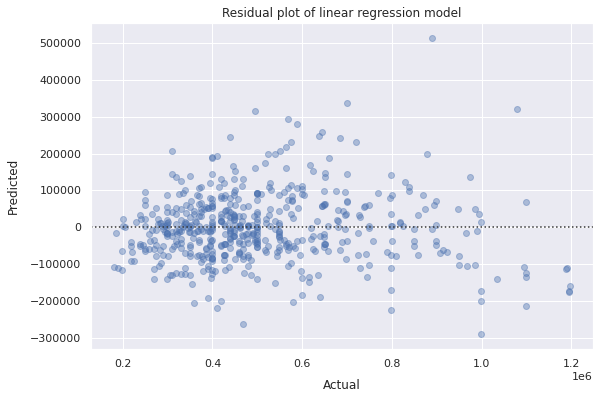

In [219]:
# Residuals plot
sns.residplot('Actual', 'Predicted', lr, scatter_kws={'alpha':0.4})
plt.title("Residual plot of linear regression model")
plt.savefig('figures/lr_residuals.png', bbox_inches='tight', dpi=300)

From the previous figures it seemed that 1.2 million dollars might be a good cutoff for the model. After this value, prediction errors increase. This is most likely because of omitted features that become more important for expensive condos such as quality of materials used for constructione.

## Predictions on entire set

In [227]:
# Price, predictinos and differences between pridicted/actual values
data_predictions = actual.copy()
predictions = lr_model.predict(features)
data_predictions["predictions"] = predictions
# Differences
data_predictions["diff"] = data_predictions.actual - data_predictions.predictions
# Add differences to data
data["diff"] = data_predictions["diff"]
# data_predictions sorted by differences
sorted_by_diff = data_predictions.sort_values(by="diff", ascending=False)
sorted_by_diff

,actual,predictions,diff
875,1149000,6.481606e+05,500839.437328
150,1190000,7.719037e+05,418096.326151
1539,999800,5.819053e+05,417894.740719
2116,1189000,7.803865e+05,408613.510860
2484,1125000,7.226932e+05,402306.753267
...,...,...,...
902,890000,1.306471e+06,-416470.865872
505,459000,8.853209e+05,-426320.911915
304,675000,1.108087e+06,-433087.327004
2634,1199000,1.667350e+06,-468349.772936


Differences between actual and pridicted prices are expected to increase with the price of a listing. Therefore, it is better to remove outlier especially if those are outside the scope of an indeviduals budget.

In [230]:
def top_false_estimates(budget, sorted_listings):
    """
    Returns indices of top 300 underestimated/overestimeated listings
    below a specified budget. Requires list sorted by differences in 
    descending order.
    """

    data = sorted_listings[sorted_listings["actual"] <= budget]
    # Top 300
    underestimates = data.head(300).index
    overestimates = data.tail(300).index
    return (underestimates, overestimates)

In [231]:
top_indices = top_false_estimates(budget=600000, sorted_listings=sorted_by_diff)
# Top overestimates
overestimate_indices = top_indices[1]
top_overestimates = data.iloc[overestimate_indices, 1 :]
# Overestimate labels
top_overestimates['overestimate'] = [1 for i in range(top_overestimates.shape[0])]
top_overestimates_coordinates = data.iloc[overestimate_indices, 2 : 4]

# Top underestimates
underestimate_indices = top_indices[0]
top_underestimate = data.iloc[underestimate_indices, 1 :]
# Underestimate labels
top_underestimate['overestimate'] = [0 for i in range(top_underestimate.shape[0])]
top_underestimate_coordinates = data.iloc[underestimate_indices, 2 : 4]

In [232]:
# Merge over and underestimates
false_estimates = pd.concat([top_overestimates, top_underestimate], axis=0)
false_estimates

,address,lat,long,price,total_area,restaurants,vibrant,cycling_friendly,historic,parks,...,greenery,year_built,unemployment_rate_2016_,bathrooms,powder_rooms,river_proximity,has_pool,has_garage,diff,overestimate
121,"5265, Rue Saint-Hubert, apt. 3, Montréal (Le P...",45.530068,-73.589791,399000,797.0,10.0,10.0,10.0,6.0,10,...,5.0,1985.0,8,1.0,0.0,False,False,True,-104370.083604,1
1193,"2530, Place Michel-Brault, apt. 424, Montréal ...",45.542334,-73.573601,379000,703.0,10.0,7.0,9.0,3.0,10,...,3.0,2015.0,8,1.0,0.0,False,True,True,-104663.589649,1
2514,"225, Rue de la Montagne, apt. 207, Montréal (L...",45.491994,-73.560333,425000,817.0,10.0,9.0,10.0,5.0,10,...,6.0,2012.0,8,1.0,0.0,False,True,True,-104815.057726,1
1502,"925, boulevard René-Lévesque Est, apt. 707., M...",45.515293,-73.556389,449000,1010.0,10.0,10.0,9.0,7.0,10,...,5.0,1995.0,10,1.0,0.0,False,False,True,-104889.039994,1
1316,"711, Rue de la Commune Ouest, apt. 606, Montré...",45.496916,-73.553175,319000,500.0,10.0,9.0,9.0,7.0,10,...,3.0,2014.0,10,1.0,0.0,False,True,False,-105083.598171,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,"1045, Rue Wellington, apt. 1902, Montréal (Le ...",45.493785,-73.557494,589000,883.0,10.0,9.0,10.0,6.0,10,...,3.0,2013.0,8,1.0,0.0,False,False,True,55476.200169,0
2344,"14399, boulevard Gouin Ouest, apt. 902, Montré...",45.493304,-73.854232,589000,972.0,5.0,2.0,4.0,2.0,7,...,6.0,2012.0,8,2.0,0.0,True,False,True,55464.840788,0
2409,"1414, Rue Chomedey, apt. 1854, Montréal (Ville...",45.491558,-73.583571,595000,721.0,10.0,10.0,5.0,7.0,10,...,7.0,2013.0,10,1.0,0.0,False,True,True,55231.086550,0
1962,"3911, boulevard Cavendish, apt. 4, Montréal (C...",45.464608,-73.630298,285000,850.0,7.0,5.0,6.0,4.0,8,...,8.0,1947.0,11,1.0,0.0,False,False,False,55014.735439,0


## Geo-Visualization of Top Listings

In [233]:
# Montreal road map from shapefile
street_map = gpd.read_file("montreal_shape/roads.shp")

In [234]:
# coordinate reference system
crs = {'init': 'epsg:4326'}
geometry = [Point(x,y) for x, y in zip(false_estimates['long'], false_estimates['lat'])]
geometry[: 3]

In [235]:
# Initialize geo data frame
geo_df = gpd.GeoDataFrame(false_estimates, crs=crs, geometry=geometry)
geo_df.tail()

,address,lat,long,price,total_area,restaurants,vibrant,cycling_friendly,historic,parks,...,year_built,unemployment_rate_2016_,bathrooms,powder_rooms,river_proximity,has_pool,has_garage,diff,overestimate,geometry
840,"1045, Rue Wellington, apt. 1902, Montréal (Le ...",45.493785,-73.557494,589000,883.0,10.0,9.0,10.0,6.0,10,...,2013.0,8,1.0,0.0,False,False,True,55476.200169,0,POINT (-73.55749 45.49378)
2344,"14399, boulevard Gouin Ouest, apt. 902, Montré...",45.493304,-73.854232,589000,972.0,5.0,2.0,4.0,2.0,7,...,2012.0,8,2.0,0.0,True,False,True,55464.840788,0,POINT (-73.85423 45.49330)
2409,"1414, Rue Chomedey, apt. 1854, Montréal (Ville...",45.491558,-73.583571,595000,721.0,10.0,10.0,5.0,7.0,10,...,2013.0,10,1.0,0.0,False,True,True,55231.086550,0,POINT (-73.58357 45.49156)
1962,"3911, boulevard Cavendish, apt. 4, Montréal (C...",45.464608,-73.630298,285000,850.0,7.0,5.0,6.0,4.0,8,...,1947.0,11,1.0,0.0,False,False,False,55014.735439,0,POINT (-73.63030 45.46461)
1476,"374, Rue du Square-Sir-George-Étienne-Cartier,...",45.473445,-73.587238,599000,1297.0,10.0,7.0,9.0,6.0,10,...,1912.0,8,1.0,0.0,False,False,False,54887.910420,0,POINT (-73.58724 45.47344)


In [236]:
# Plot geo data frame
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df.overestimate == 1].plot(ax=ax, markersize=20, color='blue', marker='o', label='Overestimate')
geo_df[geo_df.overestimate == 0].plot(ax=ax, markersize=20, color='red', marker='^', label='Underestimate')
plt.title("Top 300 over and under estimated Montreal real estate listings below $600K")
plt.legend()
plt.savefig('figures/lr_underAndOverestimates.png', bbox_inches='tight', dpi=300)
plt.close() # to decrease size of notebook

Next, we will implement a color gradient based on the `diff` feature in `sorted_by_diff`. Colors that stand out in particular regions that are dominated by colors at the opposite end of the scale might be of interest for investors.

In [237]:
# New geometry
geometry = [Point(x,y) for x, y in zip(data['long'], data['lat'])]
# New geo data frame
geo_df = gpd.GeoDataFrame(data, crs=crs, geometry=geometry).iloc[:, 1 :]

In [238]:
# Reduce outliers exceeding differences of +-400k
# For better results with color mapping
geo_df["diff_balanced"] = geo_df["diff"].\
    apply(lambda x: 400000 if x > 400000 else (-400000 if x < -400000 else x))

In [239]:
# Color pallette
# cmap = sns.cubehelix_palette(as_cmap="True", dark=0.1, light=0.95)
cmap = sns.color_palette("vlag", as_cmap=True)

In [257]:
# Plot geo data frame
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.2, color='grey')
#geo_df.plot(ax=ax, c=geo_df["diff"], cmap=cmap, markersize=5, marker='o', legend=True)
gplt.pointplot(geo_df, ax=ax, hue="diff_balanced", cmap=cmap, legend=True)
plt.title("Mapped price differences (actual - predicted)")
plt.savefig('figures/lr_mappedAccuracies.png', bbox_inches='tight', dpi=300)
plt.close() # to decrease size of notebook


## Cluster Neighbourhood Data

In this section we will first reduce the number of neighbourhood features using PCA. This will increase the performance of Kmeans which will be applied to the transformed data to aggregate and label each record. The labels will then be used to gether with geographical coordinates to visualize different types of neighbourhoods. Further analysis may reveal dominant neighbourhood patterns that correlate well with other features. Most interesting would be a correlation to the `population_variation_between_2011_2016_` feature. A similar analysis will be performed on the demographic data to identify `up-and-coming neighbourhoods`. 

In [241]:
data = pd.read_csv("data/condos.csv")

In [242]:
neighbourhood_data = ['restaurants',
       'shopping', 'vibrant', 'cycling_friendly', 'car_friendly', 'historic',
       'quiet', 'elementary_schools', 'high_schools', 'parks', 'nightlife',
       'groceries', 'daycares', 'pedestrian_friendly', 'cafes',
       'transit_friendly', 'greenery']

# Slice neighbourhood and demographic data 
neighbourhoods = data[neighbourhood_data]
# Standardize data
x = StandardScaler().fit_transform(neighbourhoods)

# PCA
pca = PCA()
pca.fit(x)
explained_variance = pca.explained_variance_
print(explained_variance)

[9.52021571 1.91409846 1.44366356 0.74696719 0.58740633 0.54607657
 0.51963175 0.46129783 0.37616865 0.24020734 0.22843392 0.15096371
 0.09878231 0.07318946 0.04929958 0.02823316 0.02171487]


In [243]:
# PCA
pca = PCA(n_components=2)
pca_transform = pca.fit_transform(x)

# K-means
k_means = KMeans(n_clusters=5)
k_means.fit(pca_transform)

KMeans(n_clusters=5)

In [244]:
# Plot axese 
axis_1 = pca_transform[:, 0]
axis_2 = pca_transform[:, 1]

Text(0, 0.5, 'PCA2')

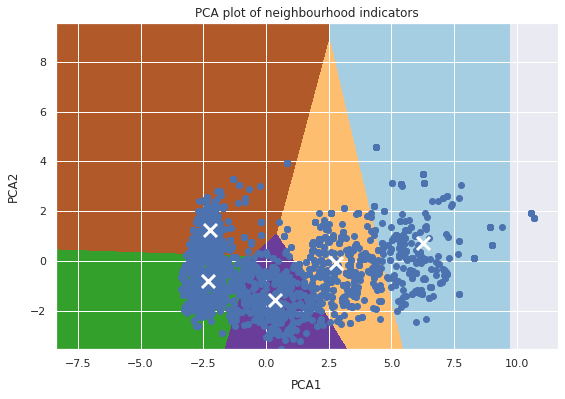

In [245]:
# 2D PCA plot with Kmeans clusters
x_min, x_max = axis_1.min() - 5, pca_transform[:, 0].max() - 1
y_min, y_max = axis_2.min(), pca_transform[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')
plt.scatter(axis_1, axis_2)
centroids = k_means.cluster_centers_
inert = k_means.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='w', zorder=8)
plt.title("PCA plot of neighbourhood indicators")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

In [246]:
print(abs( pca.components_ )[0])

[0.3101042  0.29842406 0.30735745 0.10337072 0.27297753 0.28164642
 0.15936432 0.11169115 0.1463906  0.22352887 0.29638288 0.25095667
 0.17710389 0.29001976 0.30389885 0.29447186 0.03388446]


Top neighbourhood indicators according to PCA1 components: `'restaurants', 'shopping', 'vibrant', 'nightlife','pedestrian_friendly', 'cafes', 'transit_friendly'`. 
 
This likely differentiates downtown areas from suburbs. Next we will increase the number of PCAs so that at least 80% of the variance is explained. We will then use Kmeans to cluser and label data.

In [247]:
def required_pcs(explained_variance):
    """Prints the amount of principle components needed to explain
    at least 80% of the variance in the data."""
    below_80 = False
    i = 0
    percent_var = 0

    # Find number of PCs to explain 80% variance
    while below_80 == False:
        total_variance = sum(explained_variance)
        percent_var += 100*(explained_variance[i]/total_variance)
        i += 1
        if percent_var >= 80:
            below_80 = True
    print("Number of PCs to explain 80% of variance:", i)
    print("Variance explained by {} PCs".format(i), percent_var, "%")

In [248]:
required_pcs(explained_variance)

Number of PCs to explain 80% of variance: 4
Variance explained by 4 PCs 80.11680696319559 %


In [263]:
# PCA fitting to data
pca = PCA()
pca.fit(x)

PCA()

In [264]:
# PCA tranformation of features
pca = PCA(n_components=4)
pca_transform = pca.fit_transform(x)

# K-means fitting to pca transformations
k_means = KMeans(n_clusters=5)
k_means.fit(pca_transform)

KMeans(n_clusters=5)

In [265]:
# Components of first 4 PCs
components = abs( pca.components_ )[: 4]
print(abs( pca.components_ )[: 4])

[[0.3101042  0.29842406 0.30735745 0.10337072 0.27297753 0.28164642
  0.15936432 0.11169115 0.1463906  0.22352887 0.29638288 0.25095667
  0.17710389 0.29001976 0.30389885 0.29447186 0.03388446]
 [0.06798837 0.07679919 0.12029976 0.17771019 0.12015399 0.00085033
  0.30154636 0.53299111 0.36705464 0.09209268 0.15993775 0.11551526
  0.26118785 0.12809871 0.14419063 0.06409911 0.51216897]
 [0.05507548 0.01873291 0.08112979 0.65377348 0.15216842 0.12422029
  0.41386161 0.09755917 0.42269848 0.16670244 0.09294505 0.1352747
  0.26366724 0.01159414 0.04967221 0.1347727  0.13979002]
 [0.13723423 0.18815596 0.05146184 0.13577241 0.1436125  0.10867545
  0.17610649 0.22409349 0.1600677  0.24170807 0.0662823  0.04319756
  0.55050641 0.0504753  0.02016897 0.13444506 0.62978106]]


In [296]:
def print_components(pc_n, feature_labels, components):
    """
    Returns data frame of component names and values of
    the n'th principle compenent
    """
    df = pd.DataFrame(columns=["feature", "pca_score"])
    for i in range(len(feature_labels)):
        pc_components = components[pc_n - 1] # n'th PC
        score = pc_components[i]
        label = feature_labels[i]
        new = pd.DataFrame({"feature" : label, "pca_score" : score}, index=[0])
        df = df.append(new, ignore_index=True)
    return  df

In [311]:
# PC1 components
pc_scores = print_components(pc_n=1, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

,feature,pca_score
0,restaurants,0.310104
2,vibrant,0.307357
14,cafes,0.303899
1,shopping,0.298424
10,nightlife,0.296383
15,transit_friendly,0.294472
13,pedestrian_friendly,0.290020
5,historic,0.281646
4,car_friendly,0.272978
11,groceries,0.250957


In [310]:
# PC2 components
pc_scores = print_components(pc_n=2, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

,feature,pca_score
7,elementary_schools,0.532991
16,greenery,0.512169
8,high_schools,0.367055
6,quiet,0.301546
12,daycares,0.261188
3,cycling_friendly,0.177710
10,nightlife,0.159938
14,cafes,0.144191
13,pedestrian_friendly,0.128099
2,vibrant,0.120300


In [309]:
# PC3 components
pc_scores = print_components(pc_n=3, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

,feature,pca_score
3,cycling_friendly,0.653773
8,high_schools,0.422698
6,quiet,0.413862
12,daycares,0.263667
9,parks,0.166702
4,car_friendly,0.152168
16,greenery,0.139790
11,groceries,0.135275
15,transit_friendly,0.134773
5,historic,0.124220


In [308]:
# PC4 components
pc_scores = print_components(pc_n=4, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

,feature,pca_score
16,greenery,0.629781
12,daycares,0.550506
9,parks,0.241708
7,elementary_schools,0.224093
1,shopping,0.188156
6,quiet,0.176106
8,high_schools,0.160068
4,car_friendly,0.143613
0,restaurants,0.137234
3,cycling_friendly,0.135772


*Neighbourhood aggregats*  
PC1:  -> vibrant, urban life  
PC2:  -> family friendly, green, moderately vibrant and quiet  
PC3:  -> cycling friendly, older children and quiet (boring)   
PC4:  -> young children and green (very boring)

## Cluster Demographics Data  

The objective of this section would be to identify up and coming neighbourhoods in combination with the data from the previous section.

In [81]:
demographic_data = ['less_than_$50,000_(%)',
       'between_$50,000_and_$80,000_(%)', 'between_$80,000_and_$100,000_(%)',
       'between_$100,000_and_$150,000_(%)', 'more_than_$150,000_(%)',
       '1-person_households_(%)', '2-person_households_(%)',
       '3-person_households_(%)', '4-person_households_(%)',
       '5-person_or_more_households_(%)',
       'couples_without_children_at_home_(%)',
       'couples_with_children_at_home_(%)', 'single-parent_families_(%)',
       'owners_(%)', 'renters_(%)', 'before_1960_(%)',
       'between_1961_and_1980_(%)', 'between_1981_and_1990_(%)',
       'between_1991_and_2000_(%)', 'between_2001_and_2010_(%)',
       'between_2011_and_2016_(%)', 'single-family_homes_(%)',
       'semi-detached_or_row_houses_(%)',
       'buildings_with_less_than_5_floors_(%)',
       'buildings_with_5_or_more_floors_(%)', 'mobile_homes_(%)',
       'university_(%)', 'college_(%)', 'secondary_(high)_school_(%)',
       'apprentice_or_trade_school_diploma_(%)', 'no_diploma_(%)',
       'non-immigrant_population_(%)', 'immigrant_population_(%)',
       'french_(%)', 'english_(%)', 'others_languages_(%)']

# Slice neighbourhood and demographic data 
demographics = data[demographic_data]
# Standardize data
x = StandardScaler().fit_transform(demographics)

In [82]:
# PCA
pca = PCA()
pca.fit(x)
explained_variance = pca.explained_variance_
print(explained_variance)

[1.49709932e+01 6.44142760e+00 5.17183151e+00 3.63530708e+00
 1.50542705e+00 1.15369053e+00 9.06511999e-01 6.63748134e-01
 4.51997732e-01 4.20123002e-01 2.76294706e-01 1.75164736e-01
 9.86054228e-02 6.96450144e-02 3.89246632e-02 2.16882230e-02
 9.76497794e-03 2.30228104e-03 3.65465835e-30 1.94430577e-30
 9.90983171e-31 7.65921474e-31 3.88869000e-31 2.27100033e-31
 2.11930413e-31 1.19164851e-31 1.08660842e-31 9.55784812e-32
 9.55784812e-32 9.55784812e-32 9.55784812e-32 9.55784812e-32
 9.55784812e-32 9.55784812e-32 7.53589474e-32 1.03486311e-32]


In [83]:
required_pcs(explained_variance)

Number of PCs to explain 80% of variance: 4
Variance explained by 4 PCs 83.91187512263885 %


In [86]:
pca_components = abs( pca.components_ )[: 4]
print(pca_components)

[[0.20142479 0.23059323 0.234939   0.20360778 0.0081203  0.24760239
  0.07827218 0.23950481 0.24374825 0.22413034 0.23264131 0.22585262
  0.13939814 0.21809593 0.21809593 0.05691095 0.09102231 0.11457168
  0.0375595  0.07992023 0.10673648 0.19355607 0.21291931 0.06266066
  0.19585496 0.03349179 0.21187168 0.15497305 0.19773182 0.18054488
  0.19989539 0.00991968 0.00991968 0.00270463 0.03928746 0.05517663]
 [0.01174799 0.11475539 0.0547105  0.02943497 0.17318815 0.06287273
  0.12632078 0.0704842  0.076598   0.12209139 0.00647248 0.05959488
  0.17563341 0.07469089 0.07469089 0.21189443 0.10157646 0.08393117
  0.22663527 0.23277243 0.04348274 0.11181278 0.08212587 0.3237311
  0.23033133 0.04055936 0.10462801 0.02650562 0.06019479 0.17071229
  0.13027885 0.3119949  0.3119949  0.32934424 0.25434266 0.28968477]
 [0.15423864 0.06840549 0.11940291 0.20348007 0.14385682 0.04703145
  0.2694529  0.09430866 0.08576615 0.11316434 0.16865201 0.14678013
  0.1452483  0.19652152 0.19652152 0.13048407 0

In [103]:
# PC1 components
print_components(pc_n = 1, demographics_data)

less_than_$50,000_(%) : 0.011747988213188624
between_$50,000_and_$80,000_(%) : 0.11475539297354415
between_$80,000_and_$100,000_(%) : 0.05471049682351939
between_$100,000_and_$150,000_(%) : 0.0294349704368446
more_than_$150,000_(%) : 0.17318814949387534
1-person_households_(%) : 0.06287273360934757
2-person_households_(%) : 0.1263207760488636
3-person_households_(%) : 0.07048420221351753
4-person_households_(%) : 0.07659800213070488
5-person_or_more_households_(%) : 0.12209139127335271
couples_without_children_at_home_(%) : 0.006472477809446168
couples_with_children_at_home_(%) : 0.059594878036329485
single-parent_families_(%) : 0.17563340679987743
owners_(%) : 0.07469088507378366
renters_(%) : 0.07469088507378373
before_1960_(%) : 0.21189442869807412
between_1961_and_1980_(%) : 0.10157645946164406
between_1981_and_1990_(%) : 0.08393117147306275
between_1991_and_2000_(%) : 0.22663526759803906
between_2001_and_2010_(%) : 0.23277243232600328
between_2011_and_2016_(%) : 0.0434827397473304